# **European Drug Development**

Team2: Angela Liou

[[Data Source](http://github.com/rfordatascience/tidytuesday/tree/main/data/2023/2023-03-14)]

## Milestone 4 Focus

This notebook extends the integrated M3 pipeline by strengthening the **“additional monitoring as a hub”** claim with:
- **Robustness**: bootstrap stability of lift (B=500)
- **Context checks**: topic-stratified enrichment using NMF topics (with minimum-count filters)
- **Complementary view**: a global regulatory-flag network (diagnostic)

Reproducibility notes: overall hub/bootstraps use the human subset (data_human); topic analyses use the cleaned subset with valid text/topic assignments (data_human_clean).


## **1. Data Preview & Cleaning**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
warnings.filterwarnings('ignore')

In [3]:
# import data
data = pd.read_csv('/content/drive/MyDrive/drugs.csv')
data.head()

,category,medicine_name,therapeutic_area,common_name,active_substance,product_number,patient_safety,authorisation_status,atc_code,additional_monitoring,...,marketing_authorisation_holder_company_name,pharmacotherapeutic_group,date_of_opinion,decision_date,revision_number,condition_indication,species,first_published,revision_date,url
0,human,Adcetris,"Lymphoma, Non-Hodgkin; Hodgkin Disease",brentuximab vedotin,brentuximab vedotin,2455,False,authorised,L01XC12,False,...,Takeda Pharma A/S,Antineoplastic agents,2012-07-19,2022-11-17,34.0,Hodgkin lymphomaAdcetris is indicated for adul...,NaN,2018-07-25T13:58:00Z,2023-03-13T11:52:00Z,https://www.ema.europa.eu/en/medicines/human/E...
1,human,Nityr,Tyrosinemias,nitisinone,nitisinone,4582,False,authorised,A16AX04,False,...,Cycle Pharmaceuticals (Europe) Ltd,"Other alimentary tract and metabolism products,",2018-05-31,2023-03-10,4.0,Treatment of adult and paediatric patients wit...,NaN,2018-07-26T14:20:00Z,2023-03-10T17:29:00Z,https://www.ema.europa.eu/en/medicines/human/E...
2,human,Ebvallo,Lymphoproliferative Disorders,tabelecleucel,tabelecleucel,4577,False,authorised,NaN,True,...,Pierre Fabre Medicament,NaN,2022-10-13,2023-03-09,2.0,Ebvallo is indicated as monotherapy for treatm...,NaN,2022-10-12T16:13:00Z,2023-03-10T13:40:00Z,https://www.ema.europa.eu/en/medicines/human/E...
3,human,Ronapreve,COVID-19 virus infection,"casirivimab, imdevimab","casirivimab, imdevimab",5814,False,authorised,J06BD,True,...,Roche Registration GmbH,"Immune sera and immunoglobulins,",2021-11-11,2023-02-24,3.0,Ronapreve is indicated for:Treatment of COVID-...,NaN,2021-11-12T16:30:00Z,2023-03-10T12:29:00Z,https://www.ema.europa.eu/en/medicines/human/E...
4,human,Cosentyx,"Arthritis, Psoriatic; Psoriasis; Spondylitis...",secukinumab,secukinumab,3729,False,authorised,L04AC10,False,...,Novartis Europharm Limited,Immunosuppressants,2014-11-20,2023-01-26,30.0,Plaque psoriasisCosentyx is indicated for the ...,NaN,2018-06-07T11:59:00Z,2023-03-09T18:53:00Z,https://www.ema.europa.eu/en/medicines/human/E...


In [4]:
# Split into human and veterinary data
data_human = data[data['category'] == 'human']
data_vet = data[data['category'] == 'veterinary']
print(f"Human: {data_human.shape}")
print(f"Veterinary: {data_vet.shape}")

Human: (1706, 28)
Veterinary: (282, 28)


In [5]:
# Drop columns
data_human = data_human.drop(['category', 'species', 'url', 'product_number'], axis=1)

In [6]:
# Add "admin_time_days" column
data_human['admin_time_days'] = (
    pd.to_datetime(data_human['marketing_authorisation_date'], errors='coerce') -
    pd.to_datetime(data_human['date_of_opinion'], errors='coerce')
).dt.days

data_human.head(3)

,medicine_name,therapeutic_area,common_name,active_substance,patient_safety,authorisation_status,atc_code,additional_monitoring,generic,biosimilar,...,date_of_refusal_of_marketing_authorisation,marketing_authorisation_holder_company_name,pharmacotherapeutic_group,date_of_opinion,decision_date,revision_number,condition_indication,first_published,revision_date,admin_time_days
0,Adcetris,"Lymphoma, Non-Hodgkin; Hodgkin Disease",brentuximab vedotin,brentuximab vedotin,False,authorised,L01XC12,False,False,False,...,NaN,Takeda Pharma A/S,Antineoplastic agents,2012-07-19,2022-11-17,34.0,Hodgkin lymphomaAdcetris is indicated for adul...,2018-07-25T13:58:00Z,2023-03-13T11:52:00Z,98.0
1,Nityr,Tyrosinemias,nitisinone,nitisinone,False,authorised,A16AX04,False,True,False,...,NaN,Cycle Pharmaceuticals (Europe) Ltd,"Other alimentary tract and metabolism products,",2018-05-31,2023-03-10,4.0,Treatment of adult and paediatric patients wit...,2018-07-26T14:20:00Z,2023-03-10T17:29:00Z,56.0
2,Ebvallo,Lymphoproliferative Disorders,tabelecleucel,tabelecleucel,False,authorised,NaN,True,False,False,...,NaN,Pierre Fabre Medicament,NaN,2022-10-13,2023-03-09,2.0,Ebvallo is indicated as monotherapy for treatm...,2022-10-12T16:13:00Z,2023-03-10T13:40:00Z,64.0


## **2. NLP Clustering with NMF (Non-Negative Matrix Factorization)**

In [7]:
# text preparation
data_human['condition_indication'] = data_human['condition_indication'].fillna('').astype(str)

# Keep rows with valid text and valid time calculation
data_human_clean = data_human[data_human['condition_indication'] != ''].dropna(subset=['admin_time_days']).copy()

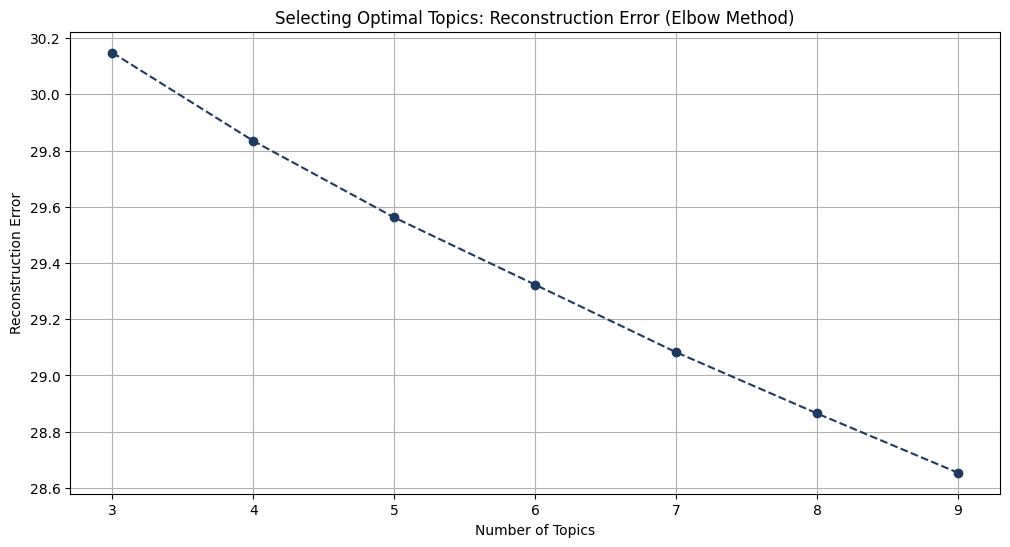

Reconstruction Errors for each k:
k=3: 30.1482
k=4: 29.8344
k=5: 29.5620
k=6: 29.3229
k=7: 29.0826
k=8: 28.8648
k=9: 28.6538


In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF

# convert the raw text into a numerical matrix
# limit to the top 1000 most frequent words
tfidf_vectorizer = TfidfVectorizer(max_features=1000, stop_words='english')
tfidf_matrix = tfidf_vectorizer.fit_transform(data_human_clean['condition_indication'])

# iterate through a range of potential topic numbers (k=3 to 9)
errors = [] # reconstruction errors
topic_range = range(3, 10)
for k in topic_range:
    nmf_demo = NMF(n_components=k, random_state=42, init='nndsvd')
    nmf_demo.fit(tfidf_matrix)
    errors.append(nmf_demo.reconstruction_err_)

# Elbow Plot
plt.figure(figsize=(12, 6))
plt.plot(topic_range, errors, marker='o', linestyle='--', color="#1f3a5f")
plt.title('Selecting Optimal Topics: Reconstruction Error (Elbow Method)')
plt.xlabel('Number of Topics')
plt.ylabel('Reconstruction Error')
plt.grid(True)
plt.show()

# error values for each k
print("Reconstruction Errors for each k:")
for k, error in zip(topic_range, errors):
    print(f"k={k}: {error:.4f}")

We can see that there's no significant elbow point, which indicates that reconstruction error keeps decreasing with increasing number of topics.

In [9]:
# k=5
n_topics = 5
nmf_model = NMF(n_components=n_topics, random_state=42, init='nndsvd')
nmf_topics = nmf_model.fit_transform(tfidf_matrix)

# topic id
data_human_clean['topic_id'] = nmf_topics.argmax(axis=1)

# print results
print("====== k=5 topics ======")
feature_names = tfidf_vectorizer.get_feature_names_out()
for topic_idx, topic in enumerate(nmf_model.components_):
    top_features_ind = topic.argsort()[:-10:-1]
    top_features = [feature_names[i] for i in top_features_ind]
    print(f"Topic {topic_idx}: {', '.join(top_features)}")

====== k=5 topics ======
Topic 0: cancer, metastatic, advanced, cell, locally, lung, small, treatment, chemotherapy
Topic 1: adults, years, adolescents, children, treatment, age, aged, older, indicated
Topic 2: diabetes, mellitus, metformin, glycaemic, control, diet, exercise, type, adjunct
Topic 3: patients, adult, treatment, indicated, disease, multiple, chronic, therapy, sclerosis
Topic 4: active, response, methotrexate, inadequate, arthritis, severe, therapy, intolerant, conventional


We selected **k = 5** because the topics are clearer and more coherent at this level.
Each topic forms a well-defined clinical theme without noticeable word mixing.
The diabetes-related terms remain grouped within a single topic, rather than being split across multiple topics.
In addition, the age-related terms form an independent topic, which improves interpretability.

In [10]:
# summary
topic_labels = {
    0: "Metastatic / Advanced Cancer (Lung, Chemotherapy)",
    1: "Age-based Indications (Adults, Children, Older)",
    2: "Type 2 Diabetes & Glycaemic Control (Metformin)",
    3: "Chronic Disease / Multiple Sclerosis",
    4: "Rheumatoid Arthritis (Methotrexate, Inadequate Response)"
}

topic_counts = data_human_clean['topic_id'].value_counts().sort_index()

# table
topic_summary_df = pd.DataFrame({
    'topic_id': topic_counts.index,
    'topic_name': topic_counts.index.map(topic_labels),
    'count': topic_counts.values
})

print(topic_summary_df)

   topic_id                                         topic_name  count
0         0  Metastatic / Advanced Cancer (Lung, Chemotherapy)    131
1         1    Age-based Indications (Adults, Children, Older)    302
2         2    Type 2 Diabetes & Glycaemic Control (Metformin)     73
3         3               Chronic Disease / Multiple Sclerosis    444
4         4  Rheumatoid Arthritis (Methotrexate, Inadequate...     66


In [11]:
# make sure topic_id is in the data
data_human_clean.head(3)

,medicine_name,therapeutic_area,common_name,active_substance,patient_safety,authorisation_status,atc_code,additional_monitoring,generic,biosimilar,...,marketing_authorisation_holder_company_name,pharmacotherapeutic_group,date_of_opinion,decision_date,revision_number,condition_indication,first_published,revision_date,admin_time_days,topic_id
0,Adcetris,"Lymphoma, Non-Hodgkin; Hodgkin Disease",brentuximab vedotin,brentuximab vedotin,False,authorised,L01XC12,False,False,False,...,Takeda Pharma A/S,Antineoplastic agents,2012-07-19,2022-11-17,34.0,Hodgkin lymphomaAdcetris is indicated for adul...,2018-07-25T13:58:00Z,2023-03-13T11:52:00Z,98.0,3
1,Nityr,Tyrosinemias,nitisinone,nitisinone,False,authorised,A16AX04,False,True,False,...,Cycle Pharmaceuticals (Europe) Ltd,"Other alimentary tract and metabolism products,",2018-05-31,2023-03-10,4.0,Treatment of adult and paediatric patients wit...,2018-07-26T14:20:00Z,2023-03-10T17:29:00Z,56.0,3
2,Ebvallo,Lymphoproliferative Disorders,tabelecleucel,tabelecleucel,False,authorised,NaN,True,False,False,...,Pierre Fabre Medicament,NaN,2022-10-13,2023-03-09,2.0,Ebvallo is indicated as monotherapy for treatm...,2022-10-12T16:13:00Z,2023-03-10T13:40:00Z,64.0,3


## **3. Additional Monitoring as a Hub (Robustness + Synergy with Topics)**

This section strengthens the M3 co-occurrence finding by adding robustness checks (bootstrap) and an unsupervised hub view (network centrality), and by validating heterogeneity across NMF topics.


### **3.1 Overall hub (human dataset): co-occurrence + enrichment**


In [12]:
# Overall co-occurrence test (Chi-square / Fisher): addditional monitoring co-occur with other 4 flags
from scipy.stats import chi2_contingency, fisher_exact

flags = [
    'additional_monitoring',
    'orphan_medicine',
    'conditional_approval',
    'exceptional_circumstances',
    'accelerated_assessment'
]

df = data_human[flags].copy()
df = df.replace({True:1, False:0})
df = df.apply(pd.to_numeric, errors='coerce').dropna()

A = 'additional_monitoring'
targets = [c for c in flags if c != A]

rows = []
for B in targets:
    p_b_given_a1 = df.loc[df[A]==1, B].mean()
    p_b_given_a0 = df.loc[df[A]==0, B].mean()
    p_b = df[B].mean()
    lift = (p_b_given_a1 / p_b) if p_b > 0 else np.nan

    # 2x2 table
    tab = pd.crosstab(df[A], df[B])
    # if any expected < 5 -> Fisher is safer
    chi2, p_chi, _, expected = chi2_contingency(tab)
    use_fisher = (expected < 5).any()
    if use_fisher:
        # fisher expects [[a,b],[c,d]] with both rows/cols present
        tab2 = tab.reindex(index=[0,1], columns=[0,1], fill_value=0)
        _, p_fisher = fisher_exact(tab2.values)
        p_val = p_fisher
        test = "Fisher"
    else:
        p_val = p_chi
        test = "Chi-square"

    rows.append({
        "flag": B,
        "P(B=1|A=1)": p_b_given_a1,
        "P(B=1|A=0)": p_b_given_a0,
        "Lift": lift,
        "p_value": p_val
    })

result = pd.DataFrame(rows).sort_values("Lift", ascending=False)
result

,flag,P(B=1|A=1),P(B=1|A=0),Lift,p_value
1,conditional_approval,0.113695,0.003033,4.040913,4.128581e-30
2,exceptional_circumstances,0.090439,0.007582,3.428653,1.898340e-18
0,orphan_medicine,0.260982,0.046247,2.748365,3.019707e-36
3,accelerated_assessment,0.025840,0.022745,1.102067,8.706688e-01


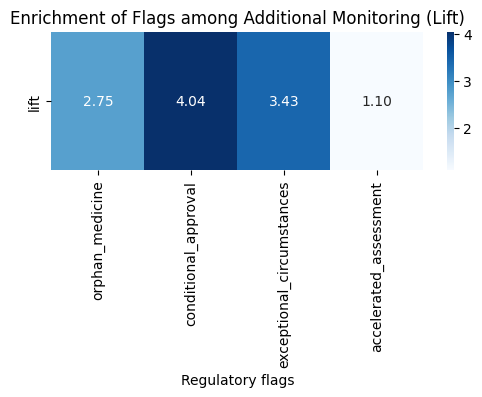

In [13]:
A = 'additional_monitoring'
targets = ['orphan_medicine', 'conditional_approval', 'exceptional_circumstances', 'accelerated_assessment']

rows = []
for B in targets:
    p_b = df[B].mean()
    p_b_given_a1 = df.loc[df[A]==1, B].mean()
    lift = (p_b_given_a1 / p_b) if p_b > 0 else np.nan
    rows.append([B, lift])

lift_df = pd.DataFrame(rows, columns=["flag", "lift"]).set_index("flag")

plt.figure(figsize=(6, 1.8))
sns.heatmap(lift_df.T, annot=True, fmt=".2f", cmap="Blues", cbar=True)
plt.title("Enrichment of Flags among Additional Monitoring (Lift)")
plt.xlabel("Regulatory flags")
plt.ylabel("")
plt.tight_layout()
plt.show()

To test whether additional monitoring functions as a “central” regulatory feature, we compared how often other special designations appear when additional monitoring is present versus absent. The results show a clear co-occurrence pattern: medicines with additional monitoring are much more likely to also receive conditional approval (11.4% vs 0.30%, lift ≈ 4.04), exceptional circumstances (9.0% vs 0.76%, lift ≈ 3.43), and orphan designation (26.1% vs 4.6%, lift ≈ 2.75). All three differences are highly significant (very small p-values), suggesting these co-occurrences are not random. In contrast, accelerated assessment does not show the same behavior (2.58% vs 2.3%, lift ≈ 1.10; p ≈ 0.87), which implies it may represent a different pathway that is not specifically tied to additional monitoring. Overall, the evidence supports the idea that additional monitoring acts as a hub-like signal around which several “special pathway” designations cluster.

### **3.2 Bootstrap stability (overall)**

This step quantifies how stable the AM-centered enrichment pattern is under resampling (B=500).


In [14]:
B = 500
rng = np.random.default_rng(42)
n = len(df)

boot_rows = []
top_counts = {b: 0 for b in targets}

for _ in range(B):
    sample = df.iloc[rng.integers(0, n, n)]  # bootstrap sample

    a1 = sample[sample[A] == 1]
    lifts = {}
    for Bflag in targets:
        p_b = sample[Bflag].mean()
        lifts[Bflag] = np.nan if (p_b == 0 or len(a1) == 0) else (a1[Bflag].mean() / p_b)

    boot_rows.append(lifts)

    s = pd.Series(lifts).dropna()
    if len(s) > 0:
        top_counts[s.idxmax()] += 1

boot_df = pd.DataFrame(boot_rows)

boot_summary = pd.DataFrame({
    "lift_mean": boot_df.mean(),
    "lift_ci2.5": boot_df.quantile(0.025),
    "lift_ci97.5": boot_df.quantile(0.975),
    "top_share": pd.Series(top_counts) / B
}).sort_values("lift_mean", ascending=False)

boot_summary


,lift_mean,lift_ci2.5,lift_ci97.5,top_share
conditional_approval,4.059473,3.627556,4.563726,0.966
exceptional_circumstances,3.441049,2.832870,4.031830,0.034
orphan_medicine,2.780199,2.446314,3.103503,0.000
accelerated_assessment,1.117706,0.529057,1.741958,0.000


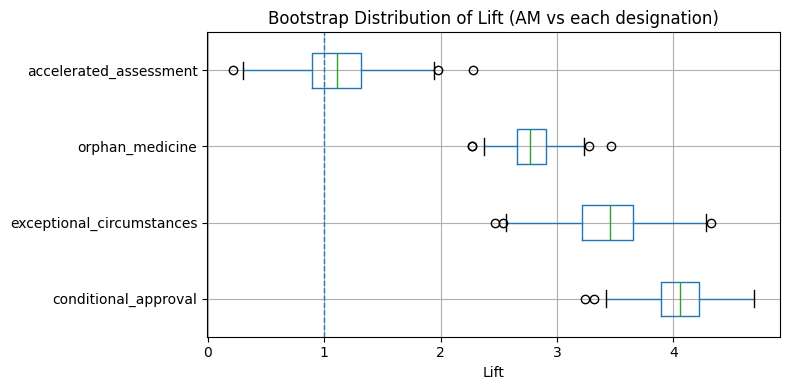

In [15]:
# boot_df: columns = flags, rows = bootstrap runs
order = boot_summary.index.tolist()  # same order as summary (highest mean first)

plt.figure(figsize=(8,4))
ax = boot_df[order].boxplot(vert=False)

plt.title("Bootstrap Distribution of Lift (AM vs each designation)")
plt.xlabel("Lift")
plt.ylabel("")

# baseline line at lift=1
plt.axvline(1, linestyle="--", linewidth=1)

plt.tight_layout()
plt.show()

I assessed the robustness of the “additional monitoring as a hub” pattern using bootstrap resampling, recomputing lift values across repeated samples. The summary results are highly consistent: conditional approval shows the strongest enrichment among AM=1 medicines (lift_mean ≈ 4.06 with a tight 95% bootstrap interval), followed by exceptional circumstances (≈ 3.44) and orphan designation (≈ 2.78). The lift boxplot reinforces this stability by showing that these three designations remain well above 1 across bootstrap runs with relatively limited spread, indicating a persistent co-occurrence signal rather than a result driven by a small number of observations. In contrast, accelerated assessment stays close to 1 with greater relative variability, suggesting little to no systematic enrichment. Overall, these bootstrap results strengthen the interpretation that additional monitoring is closely associated with a specific set of “special pathway” designations while accelerated assessment appears to reflect a different pathway.

### **3.3 Topic-stratified hub (within-topic enrichment)**

I compute within-topic lift and apply minimum-count checks (n≥50 and n_A1≥10) before interpreting topic-level patterns.


In [16]:
A = 'additional_monitoring'
targets = ['orphan_medicine','conditional_approval','exceptional_circumstances','accelerated_assessment']
flags = [A] + targets

# clean to 0/1
df_topic = data_human_clean[['topic_id'] + flags].copy()
df_topic = df_topic.replace({True:1, False:0})
df_topic[flags] = df_topic[flags].apply(pd.to_numeric, errors='coerce')
df_topic = df_topic.dropna(subset=flags)
df_topic[flags] = (df_topic[flags] > 0).astype(int)

# compute within-topic lift
rows = []
for t, g in df_topic.groupby('topic_id'):
    n = len(g)
    n_A1 = int((g[A]==1).sum())
    for B in targets:
        p_b = g[B].mean()
        p_b_given_a1 = g.loc[g[A]==1, B].mean() if n_A1 > 0 else np.nan
        lift = (p_b_given_a1 / p_b) if (p_b is not None and p_b > 0) else np.nan
        rows.append({"topic_id": t, "flag": B, "n": n, "n_A1": n_A1, "lift": lift})

topic_lift = pd.DataFrame(rows)
topic_lift.head()


,topic_id,flag,n,n_A1,lift
0,0,orphan_medicine,131,55,1.361039
1,0,conditional_approval,131,55,2.381818
2,0,exceptional_circumstances,131,55,NaN
3,0,accelerated_assessment,131,55,0.476364
4,1,orphan_medicine,302,108,2.060429


In [17]:
# Minimum-count checks
min_n = 50
min_A1 = 10

topic_lift_f = topic_lift[(topic_lift["n"] >= min_n) & (topic_lift["n_A1"] >= min_A1)].copy()

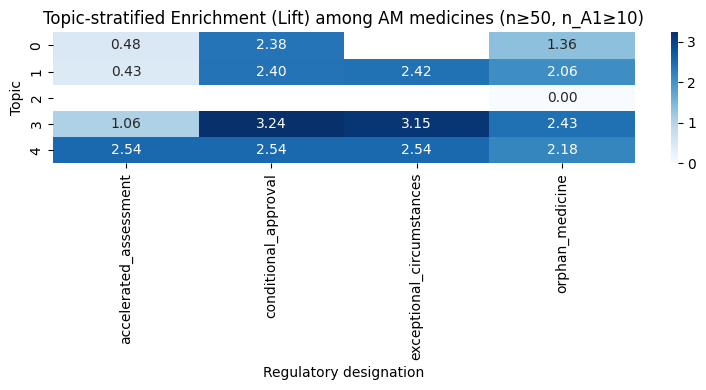

In [18]:
mat = topic_lift_f.pivot(index='topic_id', columns='flag', values='lift')

plt.figure(figsize=(8,4))
sns.heatmap(mat, annot=True, fmt=".2f", cmap="Blues")
plt.title(f"Topic-stratified Enrichment (Lift) among AM medicines (n≥{min_n}, n_A1≥{min_A1})")
plt.xlabel("Regulatory designation")
plt.ylabel("Topic")
plt.tight_layout()
plt.show()


To add interpretability to the topic-stratified hub analysis, I mapped each topic_id to its dominant indication theme: Topic 0 (Metastatic/Advanced Cancer, n=131), Topic 1 (Age-based indications, n=302), Topic 2 (Type 2 Diabetes & glycaemic control, n=73), Topic 3 (Chronic disease / Multiple sclerosis, n=444), and Topic 4 (Rheumatoid arthritis, n=66). The within-topic lift heatmap suggests that the “additional monitoring as a hub” pattern is strongest in the Multiple Sclerosis topic (Topic 3), where additional monitoring is accompanied by particularly high enrichment for conditional approval and exceptional circumstances. This indicates that, within certain chronic and high-uncertainty treatment contexts, additional monitoring tends to cluster with other special regulatory designations. By contrast, the enrichment patterns appear weaker consistent in the Cancer topics, and the smaller Diabetes and Rheumatoid Arthritis topics should be interpreted cautiously due to limited sample size. Across topics, accelerated assessment remains comparatively less aligned with the additional-monitoring bundle, reinforcing the earlier overall finding that it may represent a different pathway rather than a designation that consistently co-occurs with additional monitoring.

### **3.4 Regulatory-feature network centrality (hub analysis)**

This is a complementary diagnostic view of global connectivity among designations.


In [19]:
import networkx as nx

flags = [A] + targets

def pair_lift(g, X, Y):
    """Lift of Y given X: P(Y=1|X=1) / P(Y=1)."""
    p_y = g[Y].mean()
    if p_y == 0:
        return np.nan
    x1 = g[g[X]==1]
    if len(x1) == 0:
        return np.nan
    return x1[Y].mean() / p_y

# Build an undirected graph where edge weights are the average of the two directional lifts (X→Y and Y→X),
# so the association strength is symmetric.
G = nx.Graph()
G.add_nodes_from(flags)

for i in range(len(flags)):
    for j in range(i+1, len(flags)):
        f1, f2 = flags[i], flags[j]
        l12 = pair_lift(df, f1, f2)
        l21 = pair_lift(df, f2, f1)
        w = np.nanmean([l12, l21])
        if np.isnan(w):
            continue
        # keep only stronger edges to reduce noise in the network visualization/centrality.
        if w >= 1.2:
            G.add_edge(f1, f2, weight=float(w))

print("Nodes:", G.number_of_nodes(), "Edges:", G.number_of_edges())


Nodes: 5 Edges: 8


In [20]:
# Weighted degree (strength): sum of weights connected to each node
strength = {n: 0.0 for n in G.nodes()}
for u, v, d in G.edges(data=True):
    w = d.get("weight", 1.0)
    strength[u] += w
    strength[v] += w

strength_s = pd.Series(strength).sort_values(ascending=False)
strength_s


,0
orphan_medicine,17.871856
conditional_approval,11.522214
additional_monitoring,10.217932
exceptional_circumstances,10.004593
accelerated_assessment,8.411528


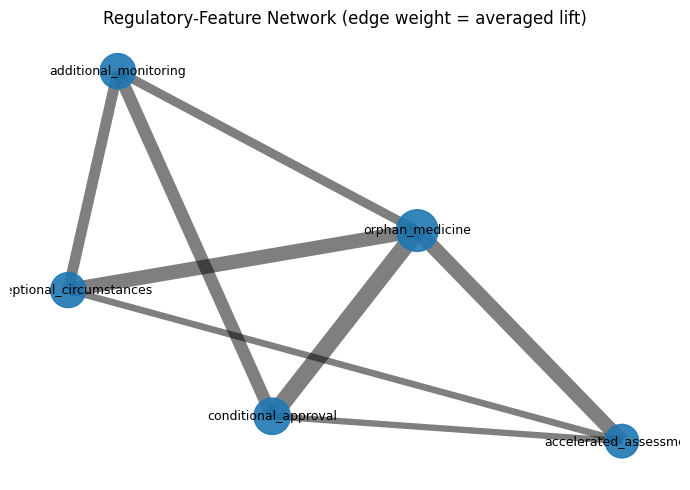

In [21]:
plt.figure(figsize=(7,5))
pos = nx.spring_layout(G, seed=42, k=0.8)

# node size by strength
sizes = [300 + 600*strength.get(n, 0) / (strength_s.max() if strength_s.max()>0 else 1) for n in G.nodes()]
# edge width by weight
widths = [1 + 2*d["weight"] for _,_,d in G.edges(data=True)]

nx.draw_networkx_nodes(G, pos, node_size=sizes, alpha=0.9)
nx.draw_networkx_edges(G, pos, width=widths, alpha=0.5)
nx.draw_networkx_labels(G, pos, font_size=9)
plt.title("Regulatory-Feature Network (edge weight = averaged lift)")
plt.axis("off")
plt.tight_layout()
plt.show()


In [22]:
B_runs = 300
rng = np.random.default_rng(42)
n = len(df)
top_hub_counts = {f: 0 for f in flags}

def build_strength_from_sample(sample, edge_thr=1.2):
    # build strength without plotting for speed
    strength = {f: 0.0 for f in flags}
    for i in range(len(flags)):
        for j in range(i+1, len(flags)):
            f1, f2 = flags[i], flags[j]
            l12 = pair_lift(sample, f1, f2)
            l21 = pair_lift(sample, f2, f1)
            w = np.nanmean([l12, l21])
            if np.isnan(w) or w < edge_thr:
                continue
            strength[f1] += w
            strength[f2] += w
    return strength

for i in range(B_runs):
    idx = rng.integers(0, n, n)
    sample = df.iloc[idx]
    sdict = build_strength_from_sample(sample, edge_thr=1.2)
    top = max(sdict, key=sdict.get)
    top_hub_counts[top] += 1

hub_stability = (pd.Series(top_hub_counts) / B_runs).sort_values(ascending=False)
hub_stability


,0
orphan_medicine,1.0
additional_monitoring,0.0
conditional_approval,0.0
exceptional_circumstances,0.0
accelerated_assessment,0.0


To complement the pairwise co-occurrence results, I represented the regulatory flags as a small association network. Each flag is treated as a node, and the edge weight between two flags is defined as the average of the two directional lifts (X→Y and Y→X), so the association strength is symmetric. I thresholded edges (e.g., average lift ≥ 1.2) to focus on stronger relationships and reduce noise, then computed weighted degree (the sum of incident edge weights for each node) as a simple measure of “hub-ness” in the network.

Under this network definition, orphan_medicine appears as the most central node, with the largest total connection strength, and bootstrap resampling confirms this ranking is stable under repeated sampling. This does not contradict the earlier “additional monitoring hub” finding, because the two analyses capture different notions of centrality: the hub test in section 3.1 is explicitly conditioned on AM=1 (i.e., which designations are enriched among AM medicines), whereas network centrality identifies which flag is most globally connected to all others under the chosen edge-weight definition. Using lift-based edges can also amplify rare-event associations, which likely contributes to orphan designation appearing highly central. Overall, I interpret this network view as a complementary perspective on overall regulatory-flag connectivity.